In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import keras
import bayesflow as bf
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.integrate import odeint

INFO:bayesflow:Using backend 'jax'


In [2]:
rng = np.random.default_rng(seed=1234)

def prior():
    x = rng.normal(size=4)
    theta = 1/(1+np.exp(-x)) * 3.9 + 0.1 # logit normal distribution scaled to range from 0.1 and 4
    return dict(
        alpha=theta[0],
        beta=theta[1],
        gamma=theta[2],
        delta=theta[3],
    )


def lotka_volterra_equations(state, t, alpha, beta, gamma, delta):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = - gamma * y + delta * x * y
    return [dxdt, dydt]


def ecology_model(alpha, beta, gamma, delta, t_span=[0, 5], t_steps=100, initial_state=[1, 1]):
    t = np.linspace(t_span[0], t_span[1], t_steps)
    state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))
    x, y = state.T  # Transpose to get x and y arrays
    
    return dict(
        x=x,  # Prey time series
        y=y,  # Predator time series
        t=t,  # time
    )


def observation_model(x, y, t, subsample=10, obs_prob=1.0, noise_scale=0.1):
    t_steps = x.shape[0]
    
    # Add Gaussian noise to observations
    noisy_x = rng.normal(x, noise_scale)
    noisy_y = rng.normal(y, noise_scale)
    
    # Determine which time steps are observed
    step_indices = np.arange(0, t_steps, subsample)
    num_observed = int(obs_prob * len(step_indices))
    observed_indices = np.sort(rng.choice(step_indices, num_observed, replace=False))

    return {
        "observed_x": noisy_x[observed_indices],
        "observed_y": noisy_y[observed_indices],
        "observed_t": t[observed_indices]
    }


In [3]:
simulator = bf.make_simulator([prior, ecology_model, observation_model])

In [4]:
adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")

    # drop unobserved full trajectories
    .drop(["x", "y", "t"])

    # add a trailing dimension of 1
    .expand_dims(["observed_x", "observed_y", "observed_t"], axis=-1)
    
    # rename the variables to match the required approximator inputs
    .concatenate(["alpha", "beta", "gamma", "delta"], into="inference_variables")
    .concatenate(["observed_x", "observed_y", "observed_t"], into="summary_variables")
)
adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Drop(['x', 'y', 't']) -> 3: ExpandDims -> 4: Concatenate(['alpha', 'beta', 'gamma', 'delta'] -> 'inference_variables') -> 5: Concatenate(['observed_x', 'observed_y', 'observed_t'] -> 'summary_variables')])

In [5]:
# We can either use separate or shared subnetworks.
# In this case, we define a single, thus shared, summary network and initialize separate inference networks.
# Note: This means that the summary network's gradients are the sum over all forward passes with the different inference networks.
#       Since the gradients will not be aligned this will not really be an effective learning rate increase by factor 3,
#       but still it will likely update faster than when training one with a single inference network.
summary_network = bf.networks.TimeSeriesNetwork()
approximator = bf.approximators.ApproximatorEnsemble(
    dict(
        cf1=bf.ContinuousApproximator(
            adapter=adapter,
            inference_network=bf.networks.CouplingFlow(),
            summary_network=summary_network,
        ),
        mvn1=bf.PointApproximator(
            adapter=adapter,
            inference_network=bf.networks.PointInferenceNetwork(scores=dict(mvn=bf.scores.MultivariateNormalScore())),
            summary_network=summary_network,
        ),
        mvn2=bf.PointApproximator(
            adapter=adapter,
            inference_network=bf.networks.PointInferenceNetwork(scores=dict(mvn=bf.scores.MultivariateNormalScore())),
            summary_network=summary_network,
        ),
    )
)

epochs = 8
batch_size = 32
num_batches = 256
num_train_sims = num_batches * batch_size

train_sims = simulator.sample(num_train_sims)
val_sims = simulator.sample(256)

dataset = bf.datasets.OfflineEnsembleDataset(
    num_ensemble=len(approximator.approximators),
    data=train_sims,
    batch_size=batch_size,
    adapter=adapter,
)

total_steps = int(epochs * num_batches)
warmup_steps = int(0.05 * epochs * num_batches)
decay_steps = total_steps - warmup_steps

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1 * 5e-4,
    warmup_target=5e-4,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0,
)
optimizer = keras.optimizers.Adam(learning_rate, clipnorm=1.5)
approximator.compile(optimizer=optimizer, metrics=None)

2025-07-04 17:39:01.977170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751643541.990236  892323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751643541.993998  892323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
history = approximator.fit(dataset=dataset, epochs=epochs, verbose=1, validation_data=adapter(val_sims))

INFO:bayesflow:Fitting on dataset instance of OfflineEnsembleDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - cf1/loss: 3.3145 - loss: 9.3006 - mvn1/loss: 3.0141 - mvn1/mvn/inference_mvn: 3.0141 - mvn2/loss: 2.9720 - mvn2/mvn/inference_mvn: 2.9720 - val_cf1/loss: 0.9200 - val_loss: 4.2394 - val_mvn1/loss: 1.6330 - val_mvn1/mvn/inference_mvn: 1.6330 - val_mvn2/loss: 1.6864 - val_mvn2/mvn/inference_mvn: 1.6864
Epoch 2/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - cf1/loss: 1.1524 - loss: 4.2894 - mvn1/loss: 1.6043 - mvn1/mvn/inference_mvn: 1.6043 - mvn2/loss: 1.5327 - mvn2/mvn/inference_mvn: 1.5327 - val_cf1/loss: 0.6453 - val_loss: 2.3177 - val_mvn1/loss: 0.6994 - val_mvn1/mvn/inference_mvn: 0.6994 - val_mvn2/loss: 0.9730 - val_mvn2/mvn/inference_mvn: 0.9730
Epoch 3/8
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - cf1/loss: 0.6570 - loss: 3.0361 - mvn1/loss: 1.2390 - mvn1/mvn/inference_mvn: 1.2390 - mvn2/loss: 1.1402 - mvn2/mvn/inference_mvn: 1.1402 - val_cf1/loss: 0.3250 - val_loss: 1.3346 - val_mvn1/loss: 0.3542 - val_mvn1/mvn/inference_mvn:

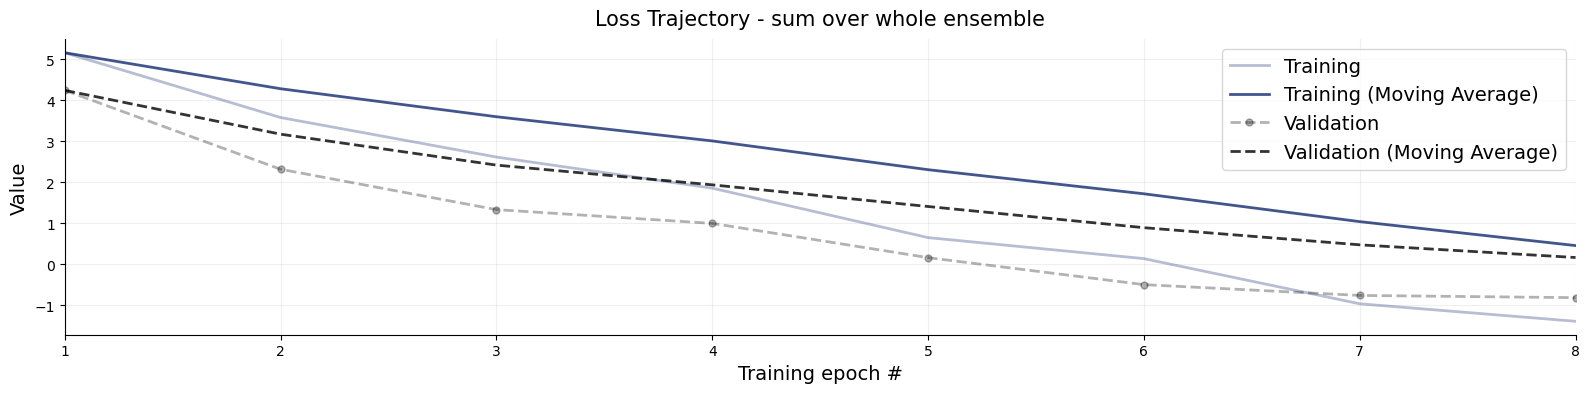

In [7]:
title_args = dict(y=1.02, size=15)
f = bf.diagnostics.loss(history)
f.gca().set_title(f"Loss Trajectory - sum over whole ensemble", **title_args);

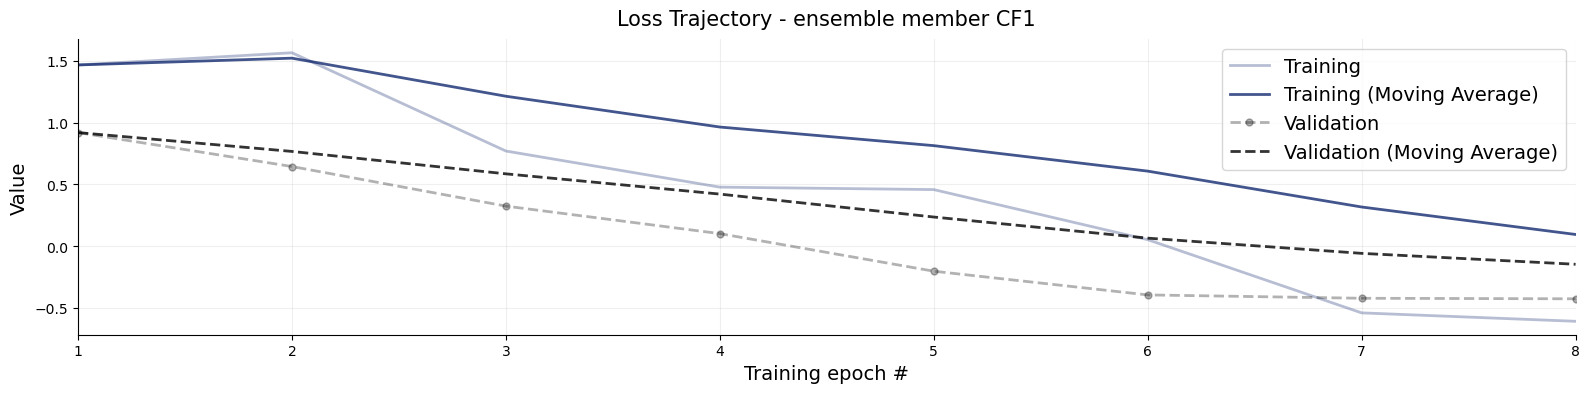

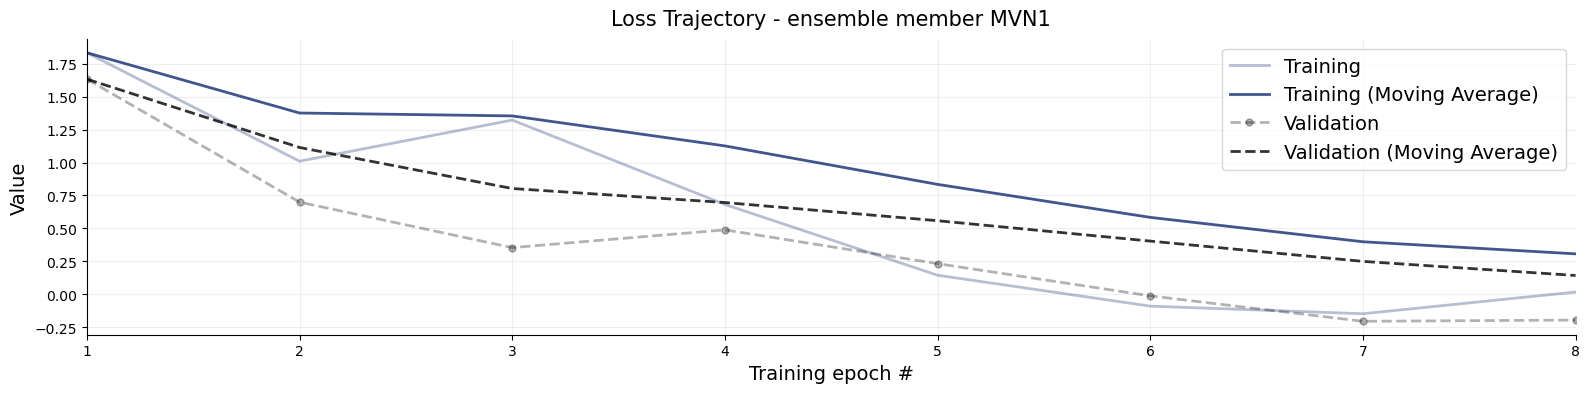

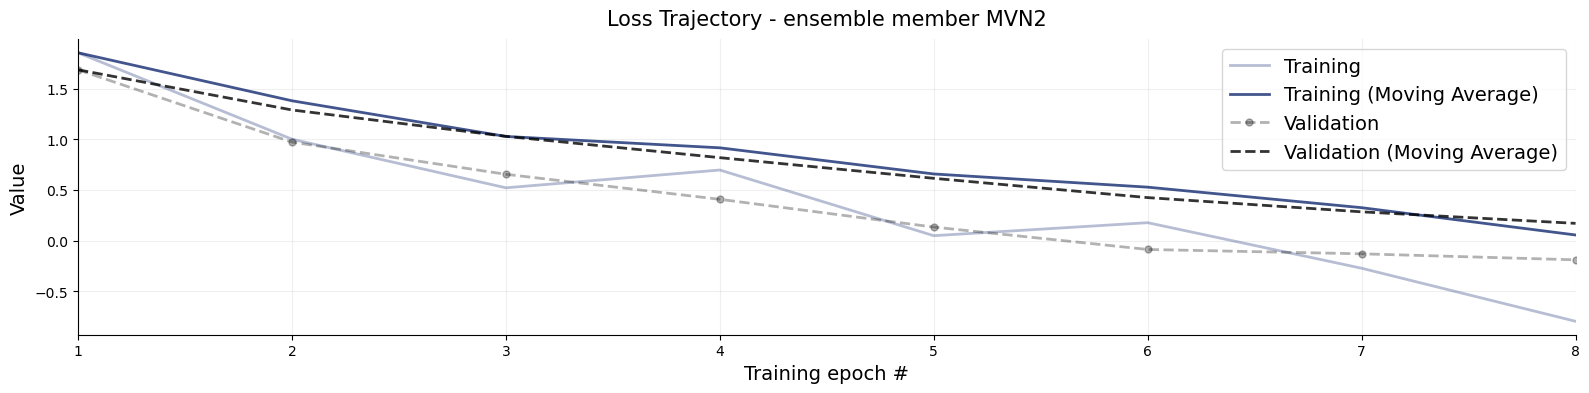

In [8]:

for k,v in approximator.approximators.items():
    f = bf.diagnostics.loss(history, train_key=f"{k}/loss", val_key=f"val_{k}/loss")
    f.gca().set_title(f"Loss Trajectory - ensemble member {k.upper()}", **title_args)

In [9]:
%%time
# Set the number of posterior draws you want to get
num_samples = 500

# Obtain posterior draws with the sample method
post_draws = approximator.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys()

CPU times: user 7.29 s, sys: 4.63 s, total: 11.9 s
Wall time: 3.78 s


dict_keys(['cf1', 'mvn1', 'mvn2'])

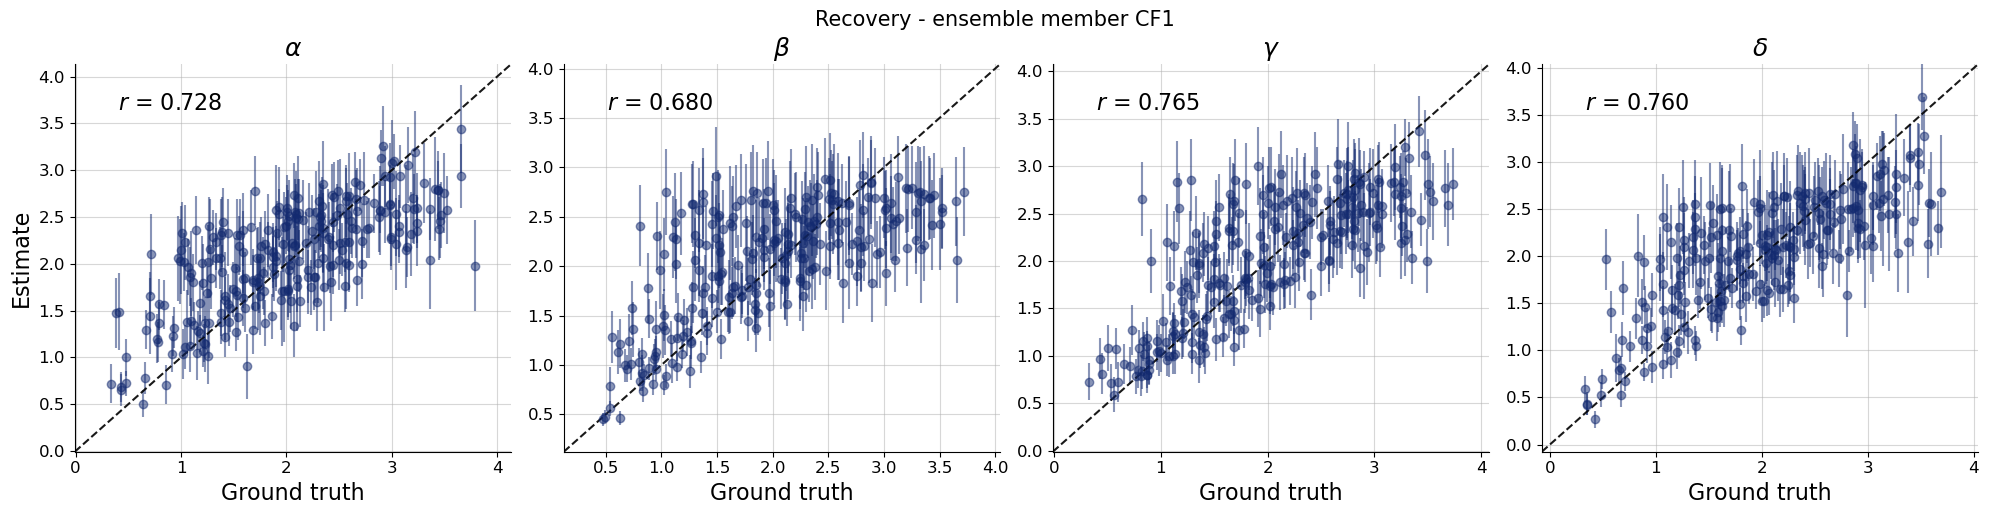

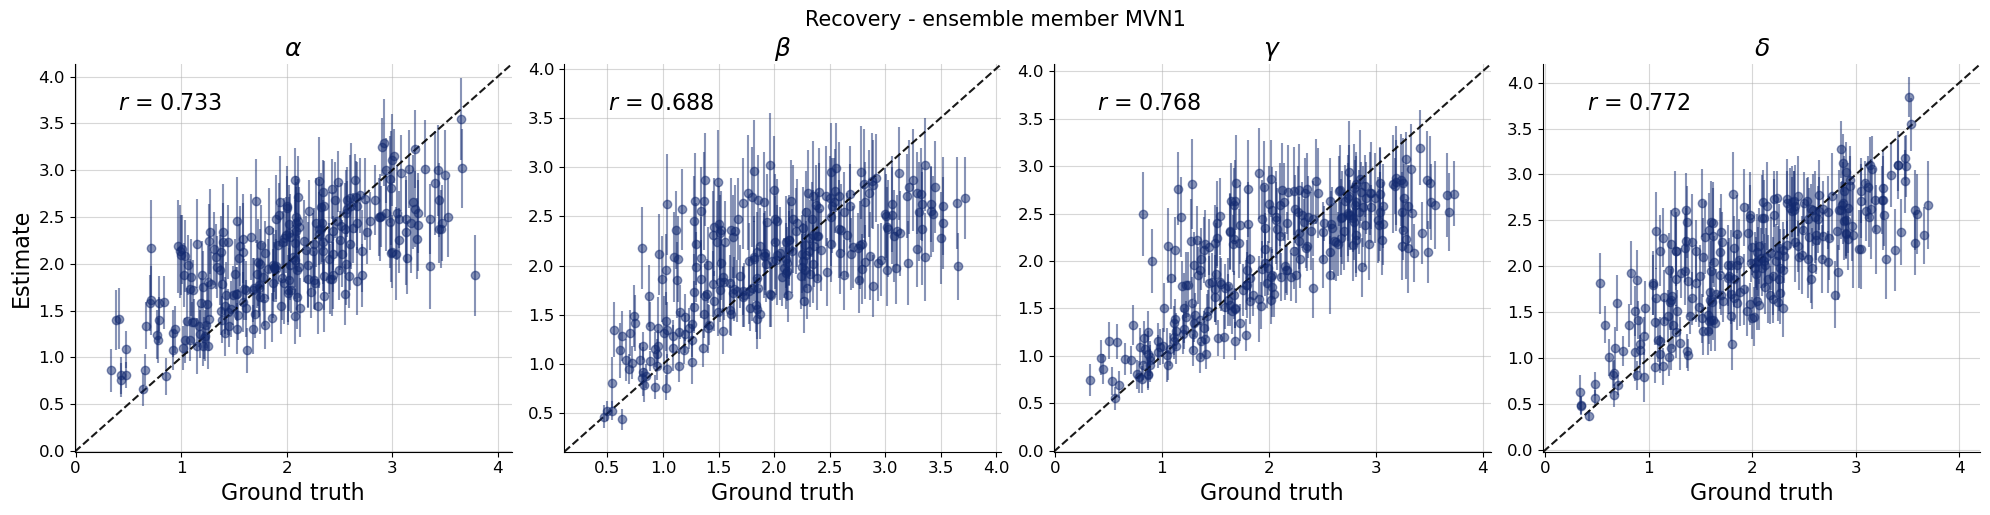

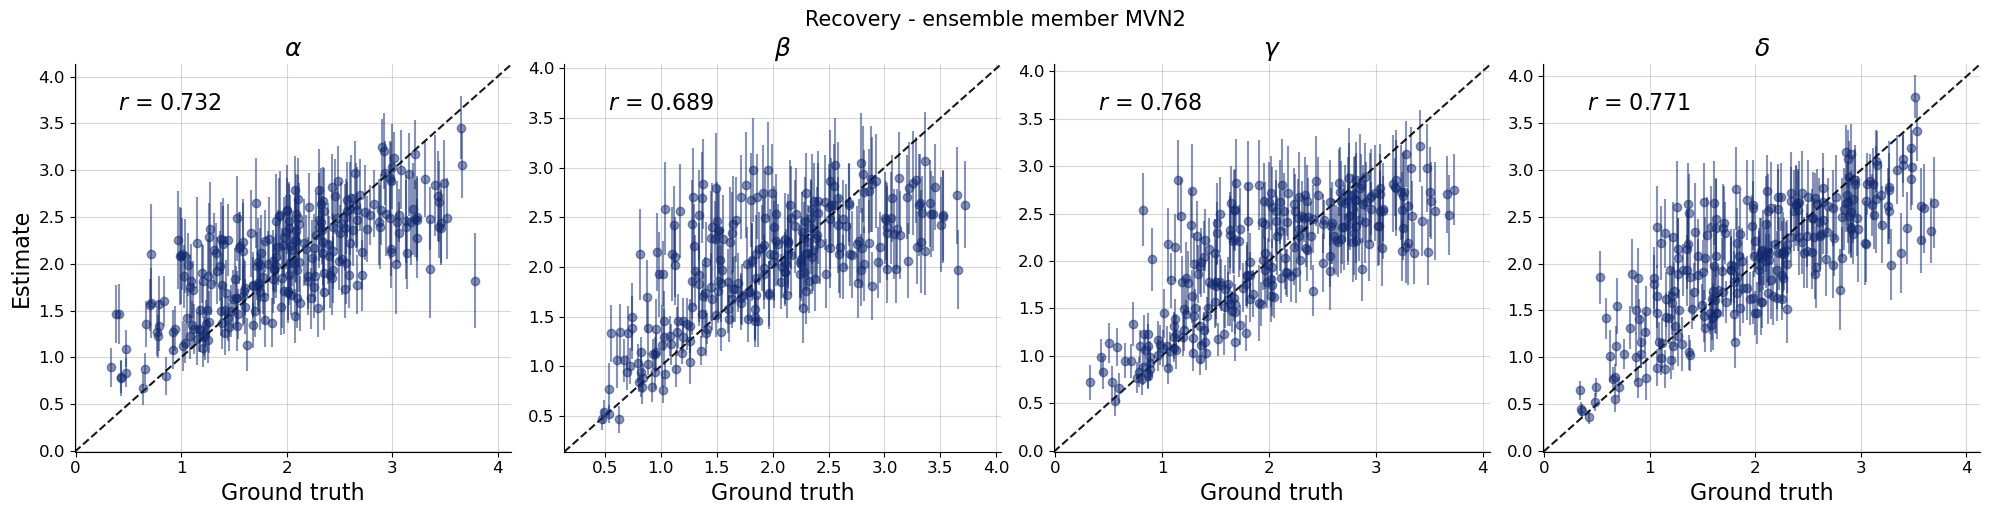

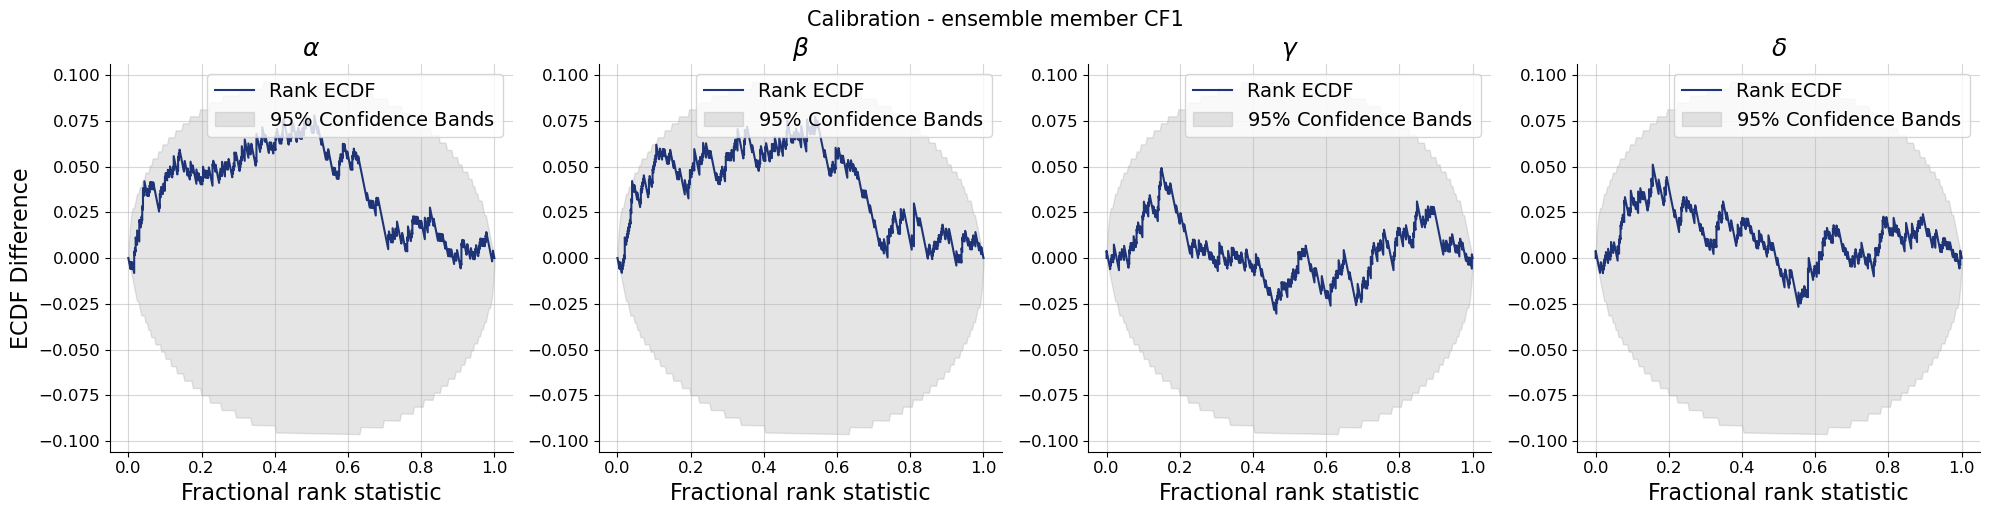

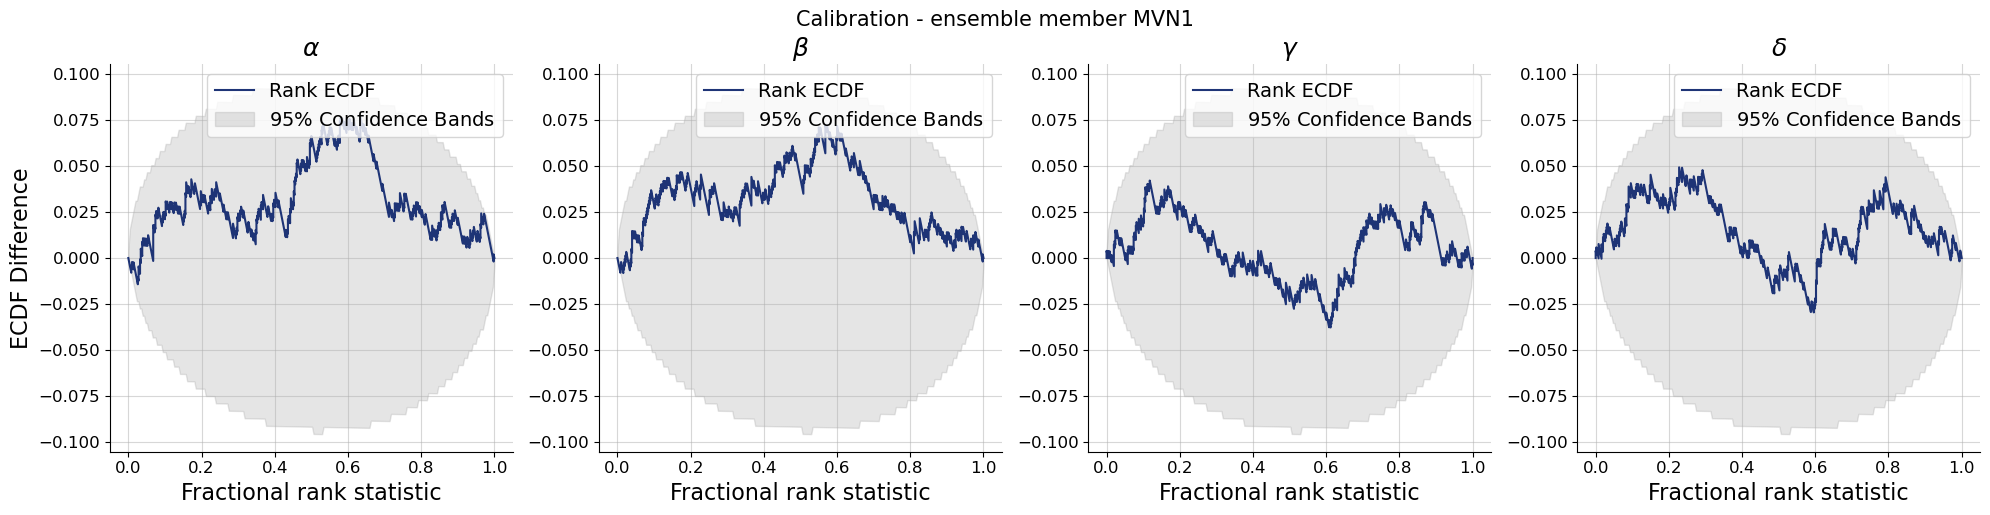

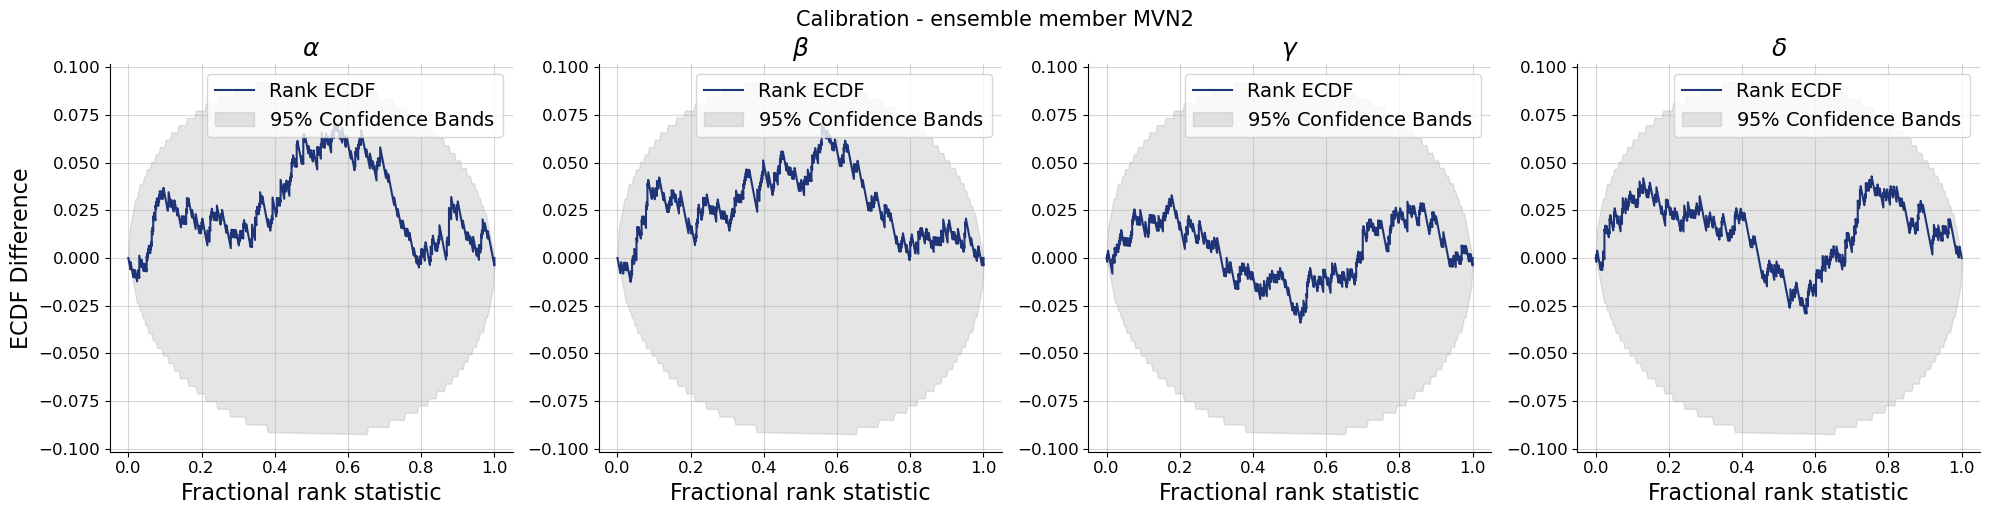

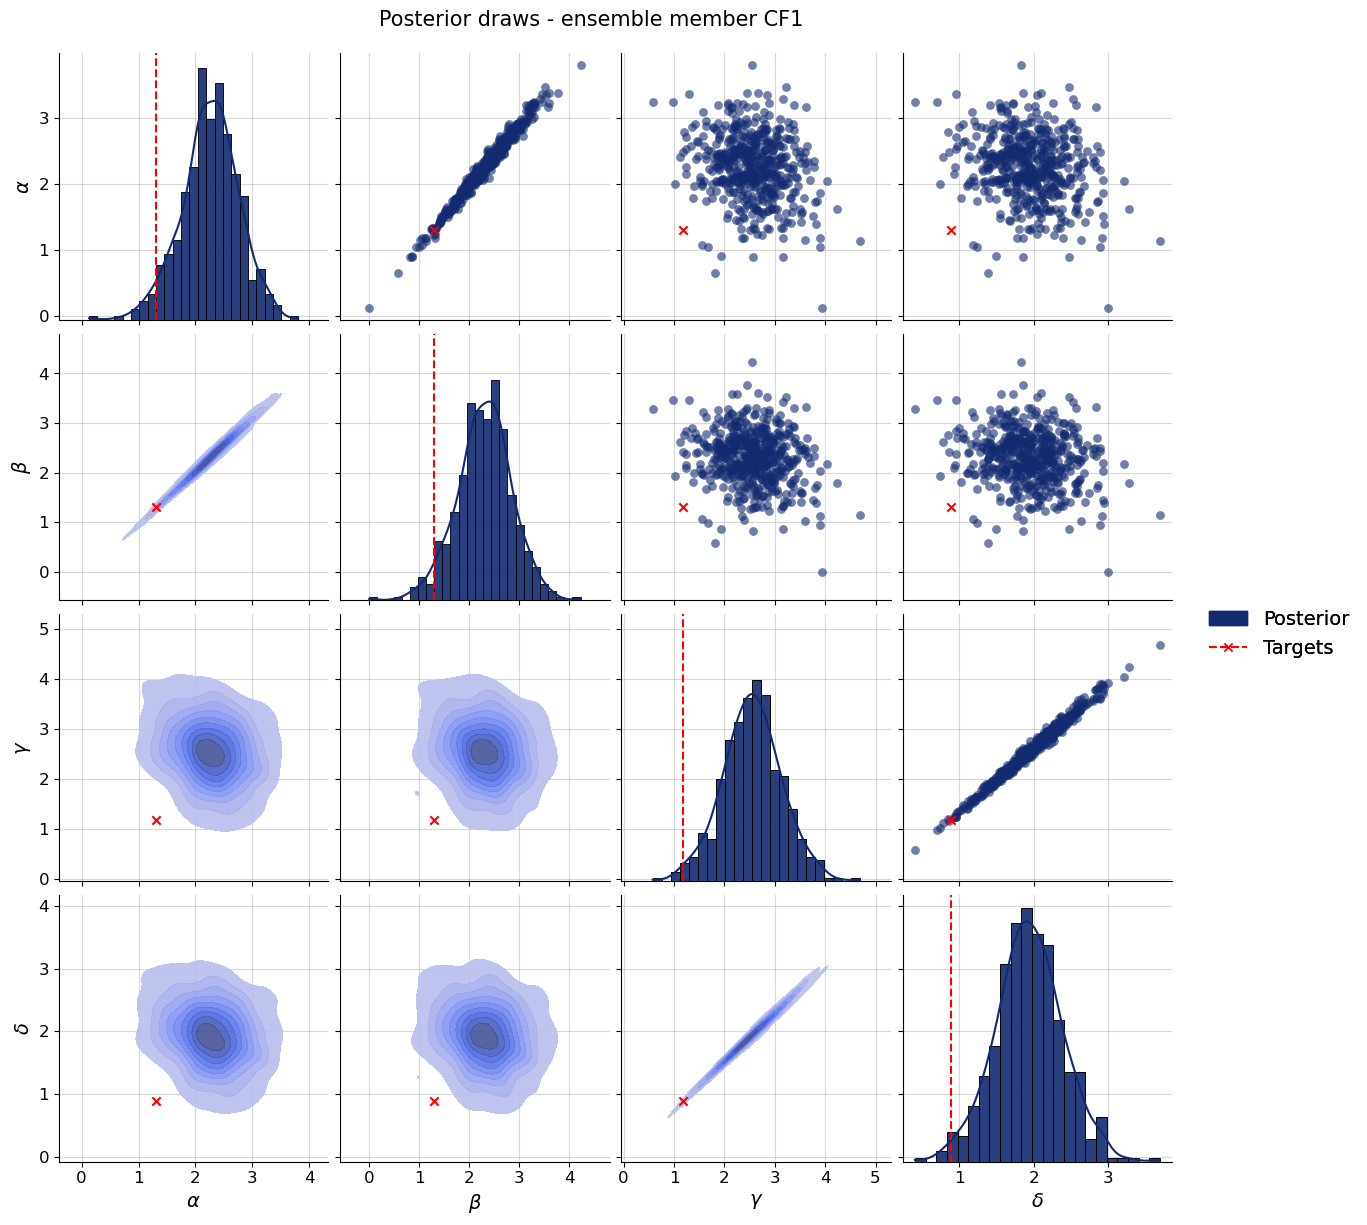

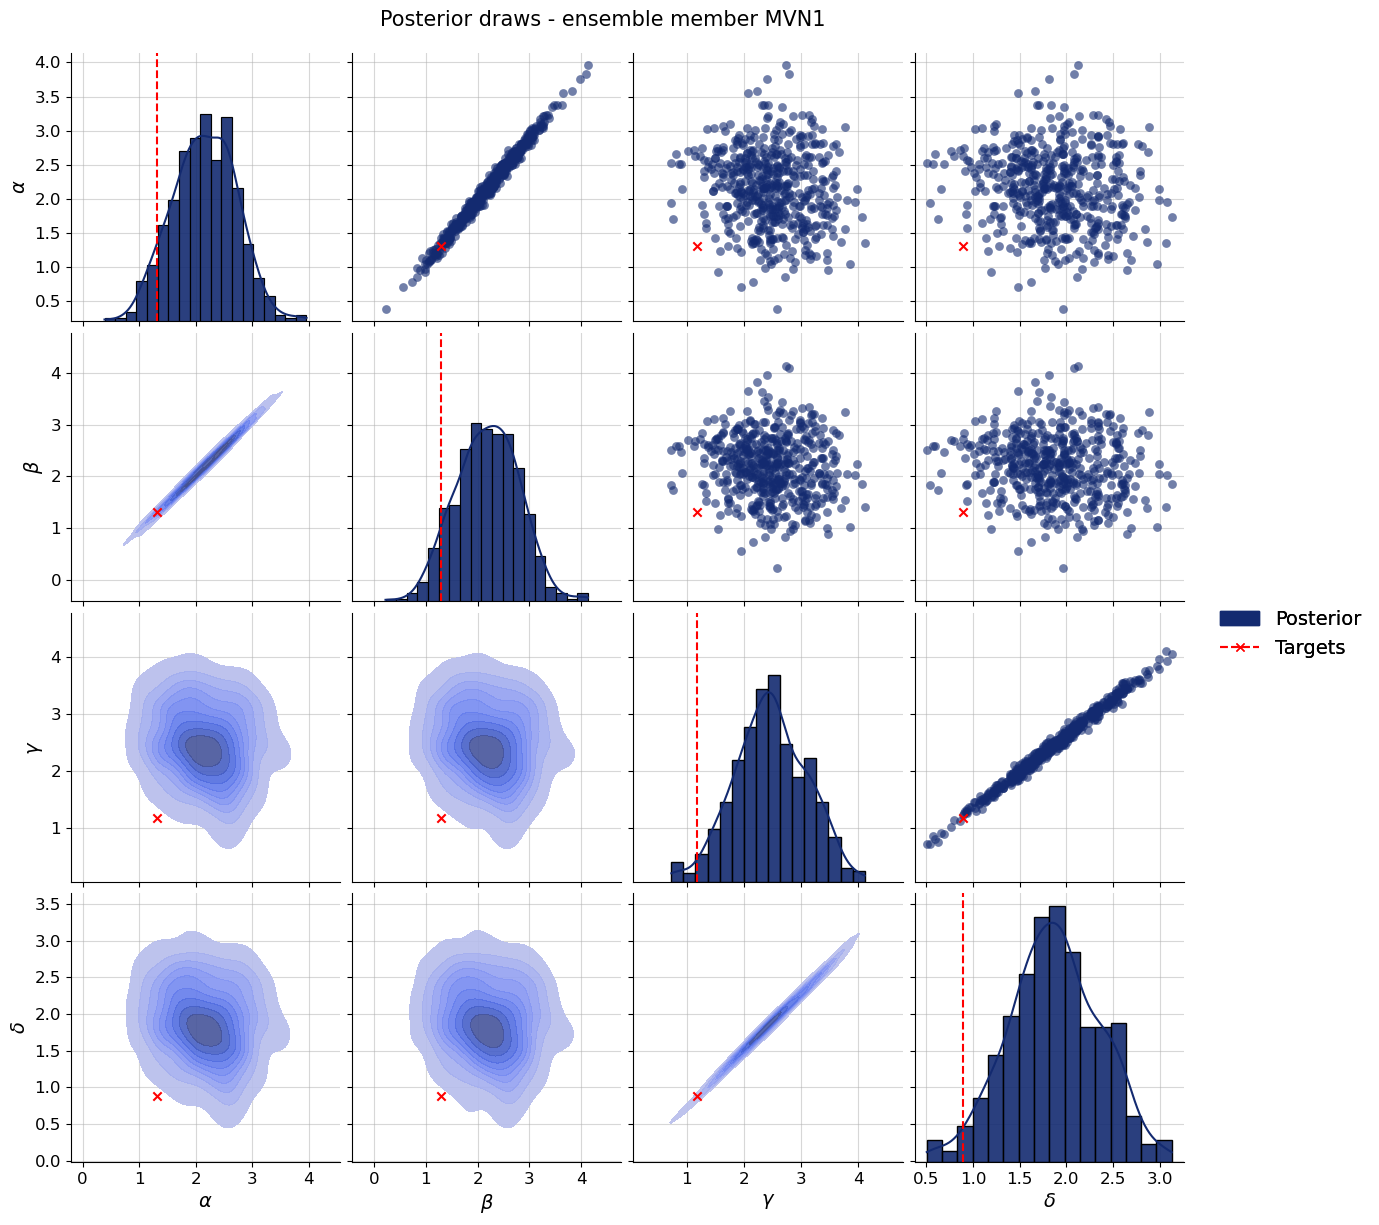

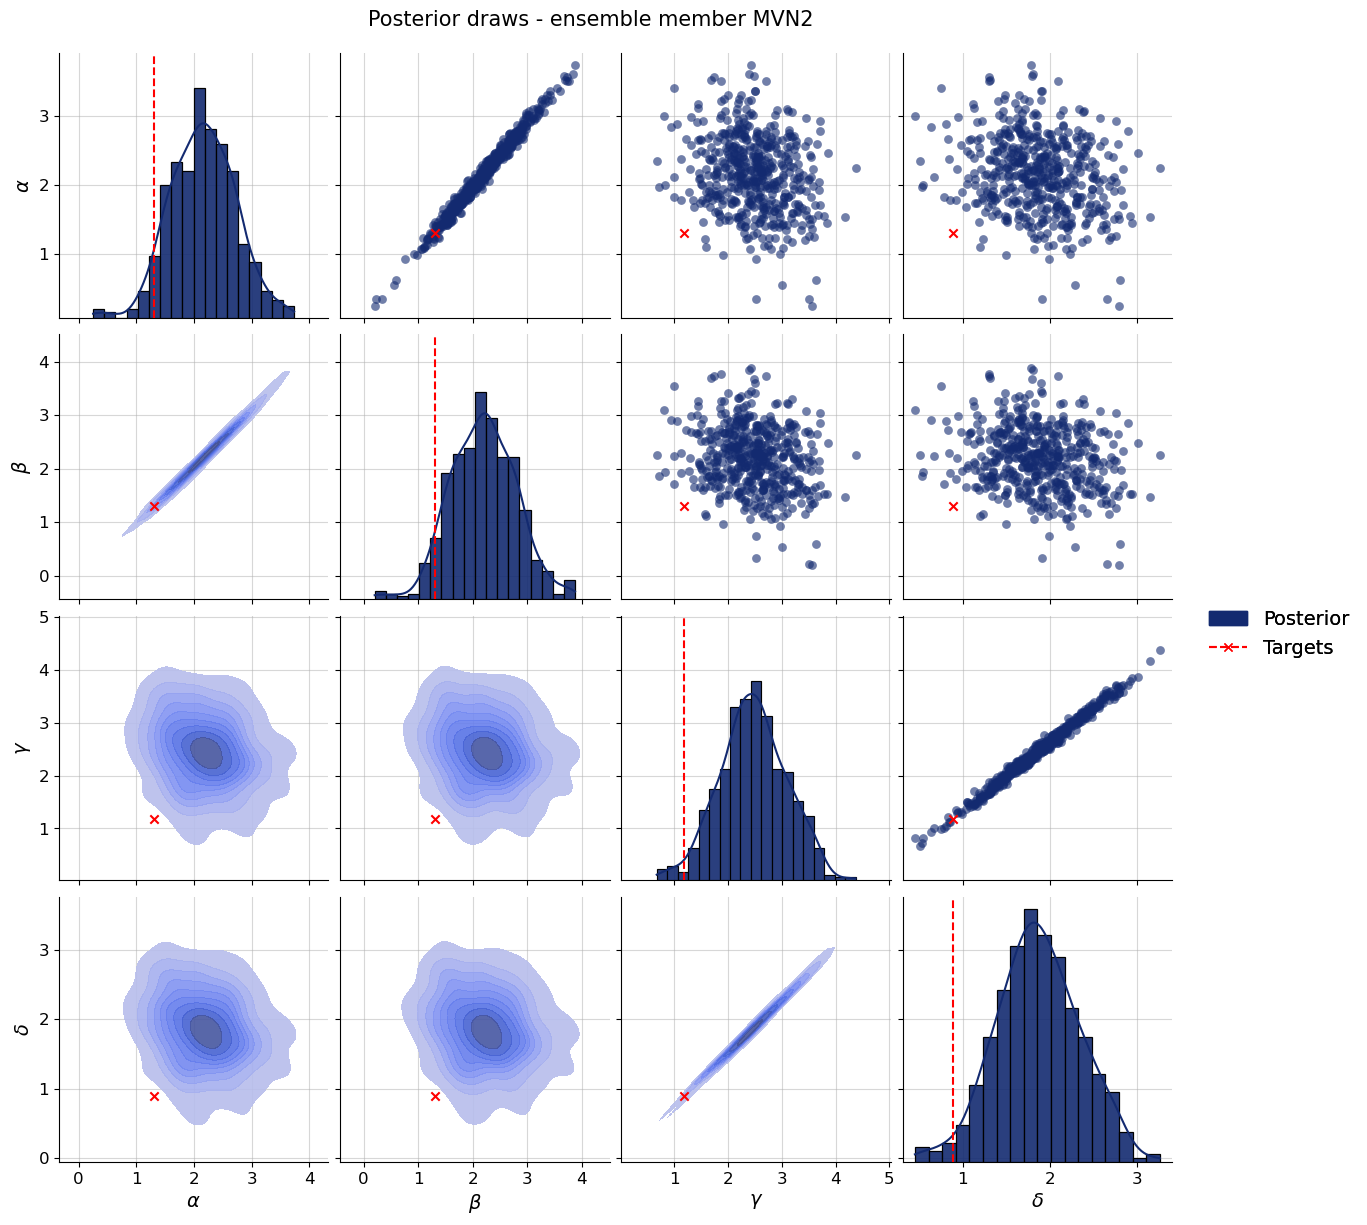

In [10]:
par_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
dataset_id = 0
for k,v in post_draws.items():
    f = bf.diagnostics.recovery(v, val_sims, variable_names=par_names)
    f.suptitle(f"Recovery - ensemble member {k.upper()}", **title_args)
for k,v in post_draws.items():
    f = bf.diagnostics.calibration_ecdf(v, val_sims, variable_names=par_names, difference=True)
    f.suptitle(f"Calibration - ensemble member {k.upper()}", **title_args)
for k,v in post_draws.items():
    g = bf.diagnostics.plots.pairs_posterior(
        estimates=post_draws[k], 
        targets=val_sims,
        dataset_id=dataset_id,
        variable_names=par_names,
    )
    g.fig.suptitle(f"Posterior draws - ensemble member {k.upper()}", **title_args)

In [11]:
def trajectory_aggregation(traj, confidence=0.95):
    alpha = 1 - confidence
    quantiles = np.quantile(traj, [alpha/2, 0.5, 1-alpha/2], axis=0).T
    central = quantiles[:,1]
    L = quantiles[:,0]
    U = quantiles[:,2]
    return central, L, U

def plot_trajectores(samples, variable_keys, variable_names, fill_colors=["blue", "darkred"], confidence=0.95, alpha=0.8, observations=None, ax=None):
    t_span = samples["t"][0]
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(12,3))
        sns.despine()
    
    for i, key in enumerate(variable_keys):

        if observations is not None:     
            ax.scatter(observations["observed_t"], observations["observed_"+key], color=fill_colors[i], marker="x", label="Observed " + variable_names[i].lower())

        central, L, U = trajectory_aggregation(samples[key], confidence=confidence)
        ax.plot(t_span, central, color=fill_colors[i], label="Median " + variable_names[i].lower())
        ax.fill_between(t_span, L, U, color=fill_colors[i], alpha=0.2, label=rf"{int((confidence) * 100)}$\%$ Confidence Bands")

        # plot 20 trajectory samples
        for j in range(20):
            if j == 0:
                label = f"{variable_names[i]} trajectories"
            else:
                label = None
            ax.plot(t_span, samples[key][j], color=fill_colors[i], alpha=0.2, label=label)
        

    ax.legend(loc="right")
    ax.set_xlabel("t")
    ax.set_ylabel("population")
    
def offline_posterior_sampler(post_draws, dataset_id, sample_id):
    posterior_sample_for_id = {var_key: post_draws[var_key][dataset_id, sample_id,...].squeeze() for var_key in post_draws.keys()}
    return posterior_sample_for_id

def take_dataset(sims, dataset_id):
    return {var_key: sims[var_key][dataset_id] for var_key in sims.keys()}

/tmp/ipykernel_892323/369446717.py:23: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  state = odeint(lotka_volterra_equations, initial_state, t, args=(alpha, beta, gamma, delta))


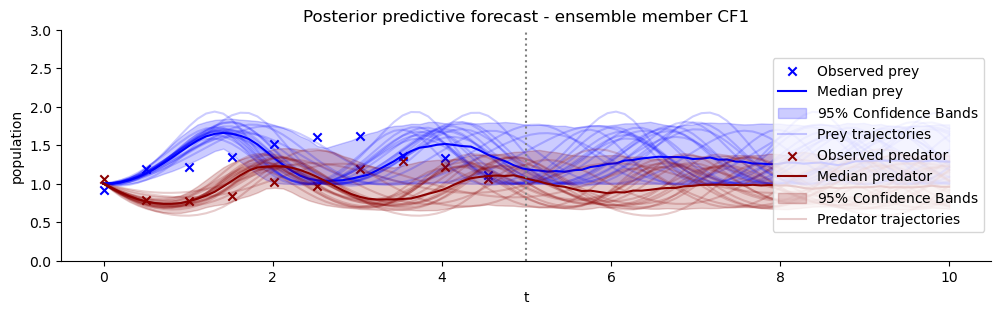

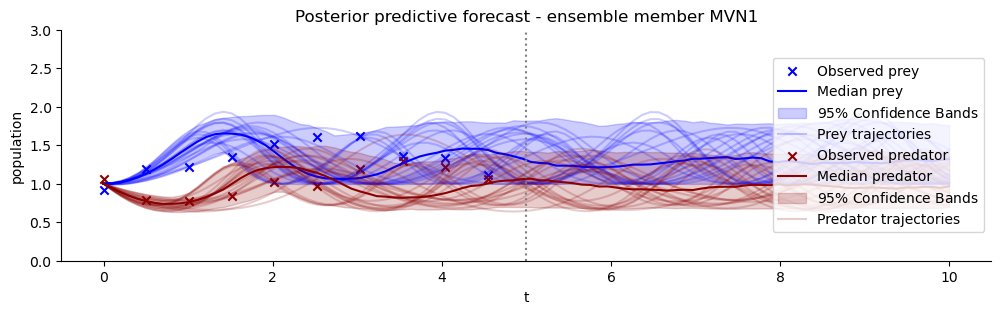

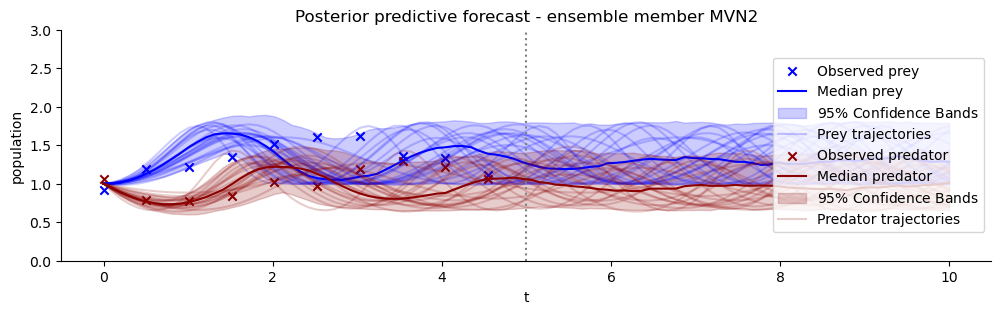

In [12]:
for k,v in post_draws.items():
    list_of_resimulations = []
    for sample_id in range(num_samples):
        one_post_sample = offline_posterior_sampler(v, dataset_id, sample_id)
        list_of_resimulations.append(ecology_model(t_span=[0,10], **one_post_sample))
    resimulation_samples = bf.utils.tree_stack(list_of_resimulations, axis=0)
    
    observations = take_dataset(val_sims, dataset_id)
    
    plot_trajectores(resimulation_samples, ["x", "y"], ["Prey", "Predator"], observations=observations)
    plt.title(f"Posterior predictive forecast - ensemble member {k.upper()}")
    plt.ylim(0,3)
    plt.axvline(5, color="grey", linestyle=":");